## INTRODUCTION
----------------------------
Name : Fajar Ibrah Muhammad

Batch : FTDS-HCK-011

Objective : Pembuatan model prediksi CNN/Computer Vision untuk prediksi Brain Tumor.

----------------------------

In [1]:
#connect gdrive for kaggle API
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## IMPORT LIBRARIES

In [95]:
import os
import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

#splitting
from sklearn.model_selection import train_test_split
from PIL import Image

#tensorflow
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#inference
import requests
from io import BytesIO

#model eval
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score, recall_score, precision_score

#tf modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense, Dropout, Flatten, Input, Concatenate

import warnings
warnings.filterwarnings('ignore')

## DATA LOADING

In [3]:
!mkdir ~/.kaggle

# !cp 'kaggle.json' ~/.kaggle
!cp '/content/drive/MyDrive/kaggle/kaggle.json' ~/.kaggle

!ls ~/.kaggle

kaggle.json


In [4]:
#download dataset
!kaggle datasets download -d preetviradiya/brian-tumor-dataset

 96% 103M/107M [00:04<00:00, 26.9MB/s] 
100% 107M/107M [00:04<00:00, 26.5MB/s]


In [5]:
!unzip -q /content/brian-tumor-dataset.zip -d images

In [6]:
os.listdir('/content/images/Brain Tumor Data Set/Brain Tumor Data Set')


['Brain Tumor', 'Healthy']

In [7]:
main_path = '/content/images/Brain Tumor Data Set/Brain Tumor Data Set'

In [8]:
tumor_dir = os.path.join(main_path, 'Brain Tumor')
healthy_dir = os.path.join(main_path, 'Healthy')

In [9]:
num_tumor= len(os.listdir(tumor_dir))
num_healthy= len(os.listdir(healthy_dir))
print(f'jumlah tumor= {num_tumor}')
print(f'jumlah healthy= {num_healthy}')

jumlah tumor= 2513
jumlah healthy= 2087


In [10]:
tumor = glob.glob(tumor_dir+"/*.jpg")
healthy = glob.glob(healthy_dir+"/*.jpg")

In [11]:
#create df for ease of use
def create_dataframe(list_of_images):
    data = []
    for image in list_of_images:
        ##ambil nama dari file \ ke -1
        # images.append(image.split('\')[-1])
        # label.append(image.split('\')[-2])
        data.append((image, image.split('/')[-2]))
    return pd.DataFrame(data, columns=['images', 'label'])

df = create_dataframe(tumor + healthy)
df = df.sample(frac=1, random_state=1).reset_index(drop=True)

In [12]:
print(df.shape)
df.head()

(4432, 2)


,images,label
0,/content/images/Brain Tumor Data Set/Brain Tum...,Brain Tumor
1,/content/images/Brain Tumor Data Set/Brain Tum...,Brain Tumor
2,/content/images/Brain Tumor Data Set/Brain Tum...,Brain Tumor
3,/content/images/Brain Tumor Data Set/Brain Tum...,Healthy
4,/content/images/Brain Tumor Data Set/Brain Tum...,Healthy


In [13]:
#Memisahkan data menjadi train, val, test

df_train, df_test= train_test_split(df, train_size=0.9, random_state=42, stratify=df['label'])

df_train, df_val= train_test_split(df_train, train_size=0.8, random_state=42, stratify=df_train['label'])

In [14]:
print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

(3190, 2)
(444, 2)
(798, 2)


## EDA

### 1. Persebaran Data Target pada Train dan Val

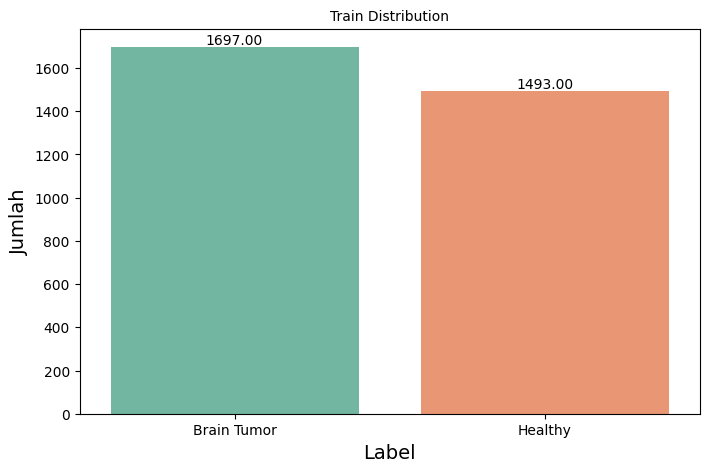

In [15]:
def visualize_data(dataframe, label):
    fig, ax = plt.subplots(figsize =(8, 5))
    ax = sns.countplot(x='label', data=dataframe, palette='Set2')
    ax.set_title('Data Distribution')
    ax.set_xlabel('Label')
    ax.set_ylabel('Count')
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'),
                   (p.get_x() + p.get_width() / 2,
                    p.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 5),
                   textcoords='offset points')

    # Setting the label for x-axis
    plt.xlabel("Label", size=14)
    # Setting the label for y-axis
    plt.ylabel("Jumlah", size=14)
    # plt title base on name of
    plt.title(f"{label} Distribution", size=10)
    plt.show()

visualize_data(df_train, 'Train')

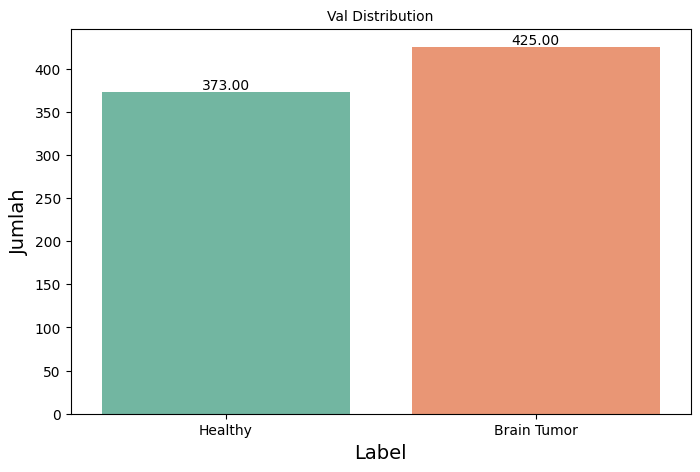

In [16]:
visualize_data(df_val, 'Val')

Terlihat distribusi label masing-masing kelas pada target sudah terbilang balanced.

### 2. Melihat perbedaan pada sample target Healthy dan Brain Tumor

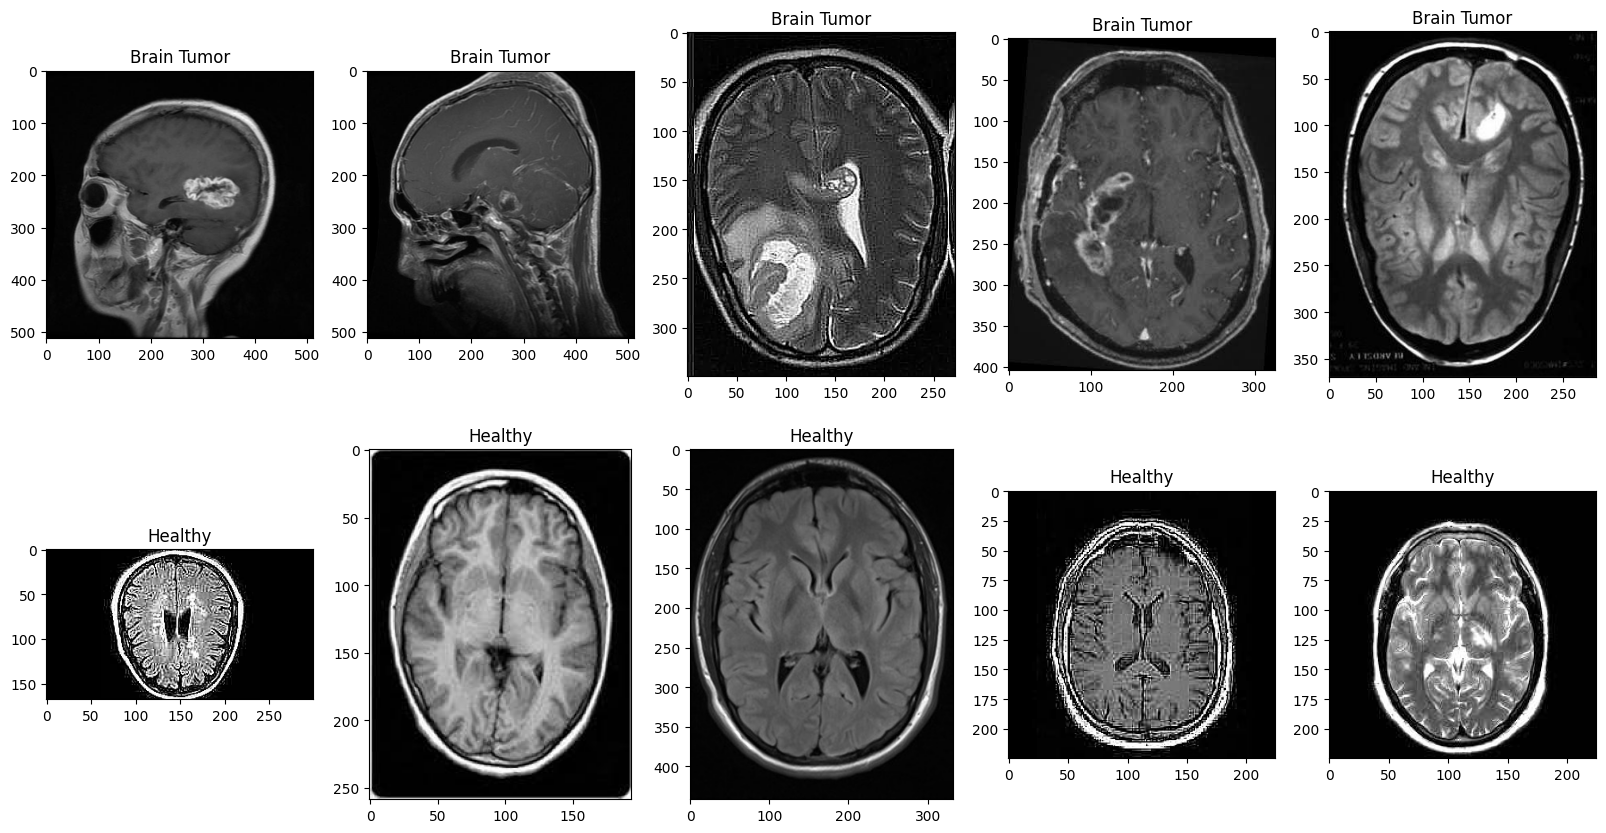

In [17]:
# Get few samples for both the classes
tumor_samples = (df_train[df_train['label']=='Brain Tumor']['images'].iloc[:5]).tolist()
healthy_samples = (df_train[df_train['label']=='Healthy']['images'].iloc[:5]).tolist()

# visualize sample images
def visualize_samples(samples):
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
    for i, sample in enumerate(samples):
        img = cv2.imread(sample)
        ax[i//5, i%5].set_title(sample.split('/')[-2])
        ax[i//5, i%5].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

visualize_samples(tumor_samples + healthy_samples)

Jika dilihat dari sample gambar masing-masing kelas yang telah ditampilkan diatas, dapat disimpulkan bahwa gambar-gambar yang ada di dalam dataset ini belum dilakukan proses Data Augmentasi, dikarenakan shape yang masih berbeda-beda. Dapat terlihat shape masing-masing gambar menggunakan fungsi dibawah.

In [28]:
def size(name):
    width = []
    height = []
    for i in name:
        p = Image.open(i)
        print(p)

In [29]:
size(tumor)
size(healthy)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=273x318 at 0x7CF5C299FF40>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=272x331 at 0x7CF5C299DA20>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=306x365 at 0x7CF5C299E980>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=311x355 at 0x7CF5C299FF40>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x7CF5C299DA20>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x7CF5C299E980>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x7CF5C299FF40>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=374x456 at 0x7CF5C299DA20>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x290 at 0x7CF5C299E980>
<PIL.JpegImagePlugin.JpegImageFile image mode=L size=1024x1024 at 0x7CF5C299FF40>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x7CF5C299DA20>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x7CF5C299E980>
<PIL.JpegImagePl

## FEATURE ENGINEERING

### Variable Initialization

In [30]:
img_height = 224
img_width = 224
epoch = 21
SEED = 1
BATCH = 64

### Data Augmentation

In [31]:
# create image generator
train_datagen = ImageDataGenerator(
    rescale=1./255, #normalisasi pixel
    rotation_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

vaL_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [32]:
# dari dataframe bukan directory
ds_train = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width), #ini buat nentuin target biar sama sizenya
    class_mode='binary',
    batch_size=BATCH,
    shuffle=True,
    seed=SEED)

ds_val = vaL_datagen.flow_from_dataframe(
    dataframe=df_val,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='binary',
    batch_size=BATCH,
    shuffle=False,
    seed=SEED)

ds_test = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='binary',
    batch_size=BATCH,
    shuffle=False,
    seed=SEED)

Found 3190 validated image filenames belonging to 2 classes.
Found 798 validated image filenames belonging to 2 classes.
Found 444 validated image filenames belonging to 2 classes.


In [33]:
ds_train.class_indices

{'Brain Tumor': 0, 'Healthy': 1}

## ANN Training Sequential API

### Model Definition

In [34]:
callbacks1 = [
    EarlyStopping(monitor='val_loss', patience= 3),
    ModelCheckpoint('model_best.hdf5', monitor='val_loss', save_best_only=True)
]

In [35]:
inputs= [img_height,img_width,3]

#arsitektur model sequential
model_base= Sequential()

#Layer Conv 1, bisa coba atur kernel_initializer dan activation
model_base.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=inputs, name= 'Conv1'))

#Layer Conv 2
model_base.add(Conv2D(filters=32, kernel_size=3, activation='relu', name= 'Conv2S'))

#Layer Conv 3
model_base.add(Conv2D(filters=64, kernel_size=3, activation='relu', name= 'Conv3'))

model_base.add(Flatten())
model_base.add(Dense(units=128, activation='relu', name= 'Dense1'))
model_base.add(Dense(units=1,activation='sigmoid', name= 'Output'))

In [36]:
model_base.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 222, 222, 16)      448       
                                                                 
 Conv2 (Conv2D)              (None, 220, 220, 32)      4640      
                                                                 
 Conv3 (Conv2D)              (None, 218, 218, 64)      18496     
                                                                 
 flatten (Flatten)           (None, 3041536)           0         
                                                                 
 Dense1 (Dense)              (None, 128)               389316736 
                                                                 
 Output (Dense)              (None, 1)                 129       
                                                                 
Total params: 389340449 (1.45 GB)
Trainable params: 3893

In [37]:
model_base.compile(loss='binary_crossentropy',
                         optimizer='adam',
                         metrics=tf.keras.metrics.Precision())

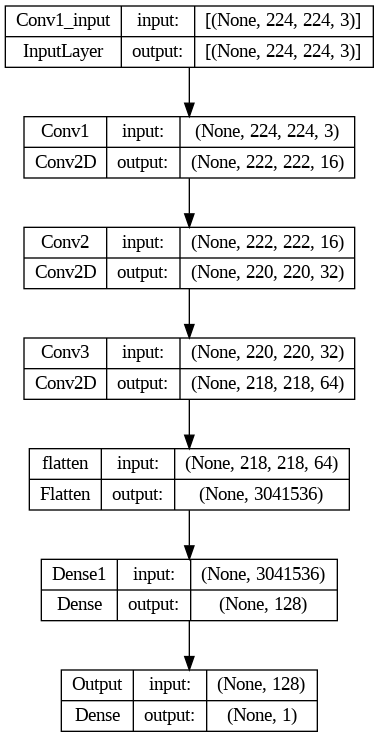

In [38]:
tf.keras.utils.plot_model(model_base, show_shapes=True)

1. `Conv1_input` menunjukkan lapisan input yang menerima gambar dengan ukuran 224x224 piksel dengan 3 kanal warna.

2. `Conv1` adalah lapisan konvolusi pertama yang mengaplikasikan 16 filter pada gambar untuk mengekstrak fitur. Ukuran output berkurang menjadi 222x222 karena filter bergerak melintasi gambar.

3. `Conv2` adalah lapisan konvolusi kedua dengan 32 filter. Ini mengurangi ukuran output lagi menjadi 220x220.

4. `Conv3` adalah lapisan konvolusi ketiga dengan 64 filter yang menghasilkan output dengan ukuran 218x218.

5. `flatten` adalah lapisan yang meratakan output dari lapisan konvolusi terakhir menjadi vektor satu dimensi agar bisa diproses oleh lapisan berikutnya.

6. `Dense1` adalah lapisan terhubung penuh (fully connected layer) yang mengambil vektor yang diratakan dan menghasilkan vektor dengan 128 nilai.

7. `Output` adalah lapisan output dengan satu neuron yang biasanya digunakan untuk tugas klasifikasi biner, seperti membedakan antara dua kelas.

### Model Training

In [39]:
history_base = model_base.fit(ds_train, batch_size = BATCH,
                           epochs = epoch, validation_data = ds_val,
                           callbacks = callbacks1)

Epoch 1/21
50/50 [==============================] - 116s 2s/step - loss: 2.8614 - precision: 0.5346 - val_loss: 0.5921 - val_precision: 0.7070
Epoch 2/21
50/50 [==============================] - 93s 2s/step - loss: 0.5205 - precision: 0.7772 - val_loss: 0.4190 - val_precision: 0.8522
Epoch 3/21
50/50 [==============================] - 52s 1s/step - loss: 0.4154 - precision: 0.8337 - val_loss: 0.4913 - val_precision: 0.9221
Epoch 4/21
50/50 [==============================] - 85s 2s/step - loss: 0.3519 - precision: 0.8702 - val_loss: 0.3707 - val_precision: 0.8827
Epoch 5/21
50/50 [==============================] - 51s 1s/step - loss: 0.3313 - precision: 0.8680 - val_loss: 0.3929 - val_precision: 0.9401
Epoch 6/21
50/50 [==============================] - 83s 2s/step - loss: 0.2886 - precision: 0.8920 - val_loss: 0.2901 - val_precision: 0.9281
Epoch 7/21
50/50 [==============================] - 91s 2s/step - loss: 0.2428 - precision: 0.9032 - val_loss: 0.2472 - val_precision: 0.8965
Epoch

### Model Evaluation

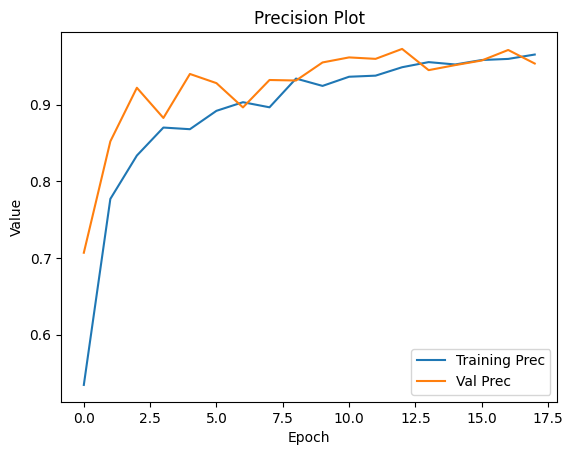

In [40]:
plt.plot(history_base.history['precision'], label='Training Prec')
plt.plot(history_base.history['val_precision'], label='Val Prec')
plt.title('Precision Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

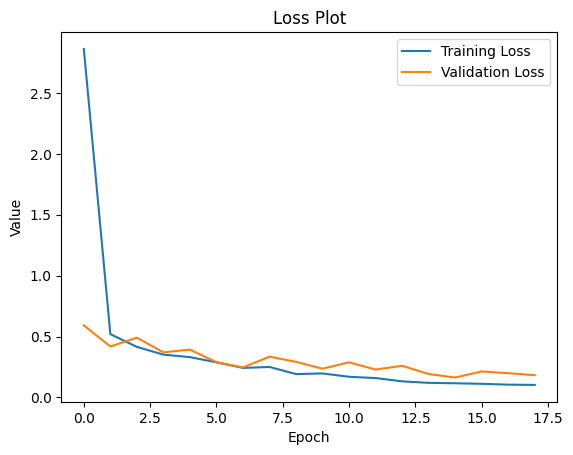

In [41]:
#loss train & validation
plt.plot(history_base.history['loss'], label='Training Loss')
plt.plot(history_base.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

In [42]:
test_results = model_base.evaluate(ds_test, verbose=0)
print(f'Test Loss     : {test_results[0]:.4f}')
print(f'Test Precision : {test_results[1]:.4f}')

Test Loss     : 0.1970
Test Precision : 0.9561


## ANN Improvement (Sequential API & Functional API)

### Sequential

#### Model Definition

In [43]:
callbacks2 = [
    EarlyStopping(monitor='val_loss', patience= 3),
    ModelCheckpoint('model_best2.hdf5', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)
]

In [44]:
inputs= [img_height,img_width,3]

#arsitektur model sequential
model_seq= Sequential()
#layer conv 1
model_seq.add(Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', input_shape=inputs))
model_seq.add(MaxPooling2D(pool_size= 2, strides=2))

#Layer Conv 2
model_seq.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
model_seq.add(MaxPooling2D(pool_size= 2, strides=2))

#Layer Conv 3
model_seq.add(Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'))
model_seq.add(MaxPooling2D(pool_size= 2, strides=2))

model_seq.add(Flatten())
model_seq.add(Dense(units=256, activation='relu'))
model_seq.add(Dense(units=512, activation='relu'))

model_seq.add(Dense(units=1,activation='sigmoid'))

In [45]:
model_seq.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 128)      

In [46]:
model_seq.compile(loss='binary_crossentropy',
                         optimizer='adamax',
                         metrics=tf.keras.metrics.Precision())

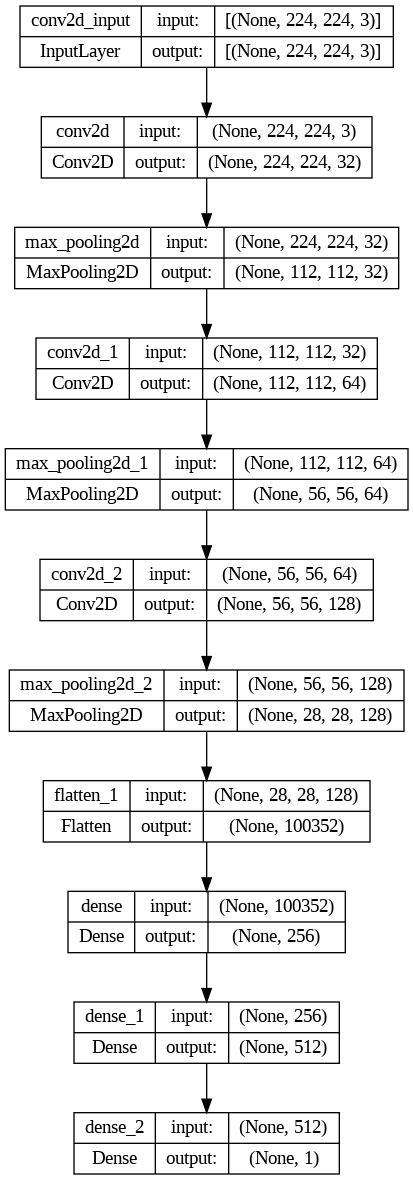

In [47]:
tf.keras.utils.plot_model(model_seq, show_shapes=True)

1. `conv2d (Conv2D)`: Ini adalah lapisan konvolusi 2D dengan 32 filter dan ukuran kernel (3, 3). Lapisan ini digunakan untuk mengekstraksi fitur-fitur dari gambar input. Ukuran outputnya adalah (None, 224, 224, 32).

2. `max_pooling2d (MaxPooling2D)`: Lapisan max-pooling 2D yang digunakan untuk mereduksi dimensi spasial dari keluaran lapisan konvolusi sebelumnya. Dalam hal ini, ia membagi dimensi menjadi separuhnya, menghasilkan ukuran output (None, 112, 112, 32).

3. `conv2d_1 (Conv2D)`: Ini adalah lapisan konvolusi 2D lainnya dengan 64 filter dan ukuran kernel (3, 3). Lapisan ini digunakan untuk mengekstraksi fitur lebih lanjut dari gambar setelah proses max-pooling. Ukuran outputnya adalah (None, 112, 112, 64).

4. `max_pooling2d_1 (MaxPooling2D)`: Lapisan max-pooling 2D yang kembali mereduksi dimensi spasial menjadi separuhnya dari keluaran lapisan konvolusi sebelumnya, menghasilkan ukuran output (None, 56, 56, 64).

5. `conv2d_2 (Conv2D)`: Lapisan konvolusi 2D ketiga dengan 128 filter dan ukuran kernel (3, 3). Lapisan ini digunakan untuk terus mengekstraksi fitur lebih lanjut dari gambar setelah proses max-pooling. Ukuran outputnya adalah (None, 56, 56, 128).

6. `max_pooling2d_2 (MaxPooling2D)`: Lapisan max-pooling 2D yang lagi-lagi mereduksi dimensi spasial menjadi separuhnya dari keluaran lapisan konvolusi sebelumnya, menghasilkan ukuran output (None, 28, 28, 128).

7. `flatten_1 (Flatten)`: Lapisan ini digunakan untuk mengubah output dari lapisan konvolusi menjadi bentuk vektor 1D. Dalam hal ini, vektor tersebut memiliki panjang 100352.

8. `dense (Dense)`: Lapisan ini adalah lapisan terhubung penuh (fully connected) dengan 256 unit. Lapisan ini bertujuan untuk melakukan pembelajaran lebih lanjut pada fitur-fitur yang telah diekstraksi sebelumnya.

9. `dense_1 (Dense)`: Lapisan terhubung penuh kedua dengan 512 unit. Ini merupakan lapisan yang lebih dalam dalam jaringan dan dapat menghasilkan representasi yang lebih kompleks dari data.

10. `dense_2 (Dense)`: Lapisan terhubung penuh terakhir dengan hanya satu unit. Biasanya, lapisan seperti ini digunakan untuk tugas klasifikasi biner di mana outputnya mungkin menjadi 0 atau 1.

#### Model Training

In [48]:
history_seq = model_seq.fit(ds_train, batch_size = BATCH,
                           epochs = epoch, validation_data = ds_val,
                           callbacks = callbacks2)

Epoch 1/21
50/50 [==============================] - 54s 969ms/step - loss: 0.7063 - precision_1: 0.5411 - val_loss: 0.5837 - val_precision_1: 0.6130 - lr: 0.0010
Epoch 2/21
50/50 [==============================] - 48s 940ms/step - loss: 0.5424 - precision_1: 0.7526 - val_loss: 0.5162 - val_precision_1: 0.9057 - lr: 0.0010
Epoch 3/21
50/50 [==============================] - 48s 973ms/step - loss: 0.4472 - precision_1: 0.8217 - val_loss: 0.4082 - val_precision_1: 0.8639 - lr: 0.0010
Epoch 4/21
50/50 [==============================] - 47s 944ms/step - loss: 0.3954 - precision_1: 0.8396 - val_loss: 0.3631 - val_precision_1: 0.8534 - lr: 0.0010
Epoch 5/21
50/50 [==============================] - 47s 922ms/step - loss: 0.3496 - precision_1: 0.8556 - val_loss: 0.3900 - val_precision_1: 0.8605 - lr: 0.0010
Epoch 6/21
50/50 [==============================] - 46s 922ms/step - loss: 0.3168 - precision_1: 0.8702 - val_loss: 0.4622 - val_precision_1: 0.9416 - lr: 0.0010
Epoch 7/21
50/50 [==========

#### Model Evaluation

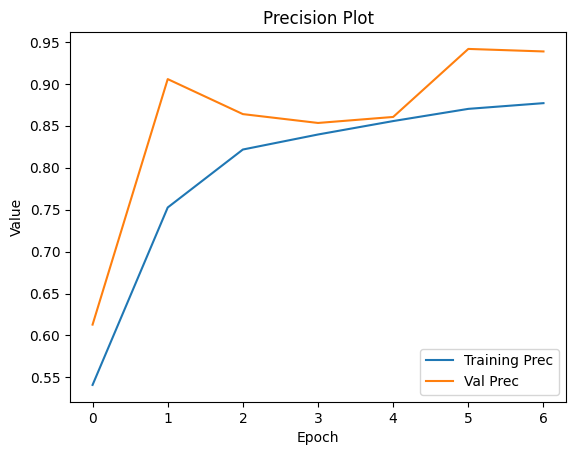

In [49]:
plt.plot(history_seq.history['precision_1'], label='Training Prec')
plt.plot(history_seq.history['val_precision_1'], label='Val Prec')
plt.title('Precision Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

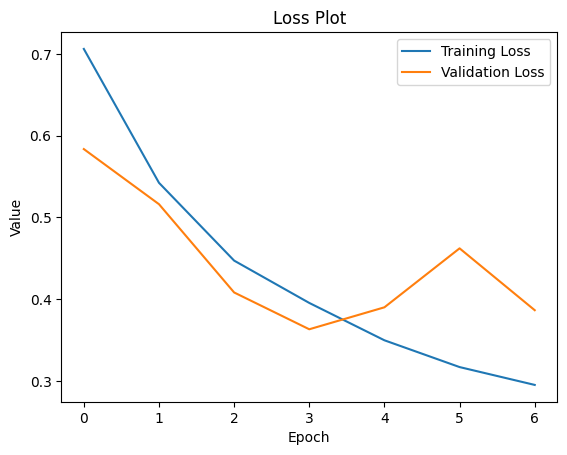

In [50]:
#loss train & validation
plt.plot(history_seq.history['loss'], label='Training Loss')
plt.plot(history_seq.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

In [51]:
test_results = model_seq.evaluate(ds_test, verbose=0)
print(f'Test Loss     : {test_results[0]:.4f}')
print(f'Test Precision : {test_results[1]:.4f}')

Test Loss     : 0.4077
Test Precision : 0.9057


### Functional

#### Model Definition

In [52]:
callbacks3 = [
    EarlyStopping(monitor='val_loss', patience= 3),
    ModelCheckpoint('model_best3.hdf5', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)
]

In [53]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate
from keras.models import Model

# Define input tensor
inputs = Input(shape=(img_height, img_width, 3))

# Convolutional and pooling layers
conv1 = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(inputs)

conv2 = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)

pool1 = MaxPooling2D(pool_size=2)(conv1)
pool2 = MaxPooling2D(pool_size=2)(conv2)

concatenated = Concatenate()([pool1, pool2])

# Flatten the output of the last pooling layer
flat = Flatten()(concatenated)

# Dense layers
dense_1 = Dense(10, activation='relu')(flat)
dense_2 = Dense(10, activation='relu')(flat)

# Concatenate the flat layer with one of the dense layers (mimicking the uploaded architecture)
concatenated2 = Concatenate()([dense_1, dense_2])

# Output layer
output_layer = Dense(1, activation='sigmoid')(concatenated2)

# Create the model
model_func = Model(inputs=inputs, outputs=output_layer)

# Model summary
model_func.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 224, 224, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv2d_4 (Conv2D)           (None, 224, 224, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 112, 112, 32)         0         ['conv2d_3[0][0]']            
 g2D)                                                                                         

In [54]:
model_func.compile(loss='binary_crossentropy',
                         optimizer='adamax',
                         metrics=tf.keras.metrics.Precision())

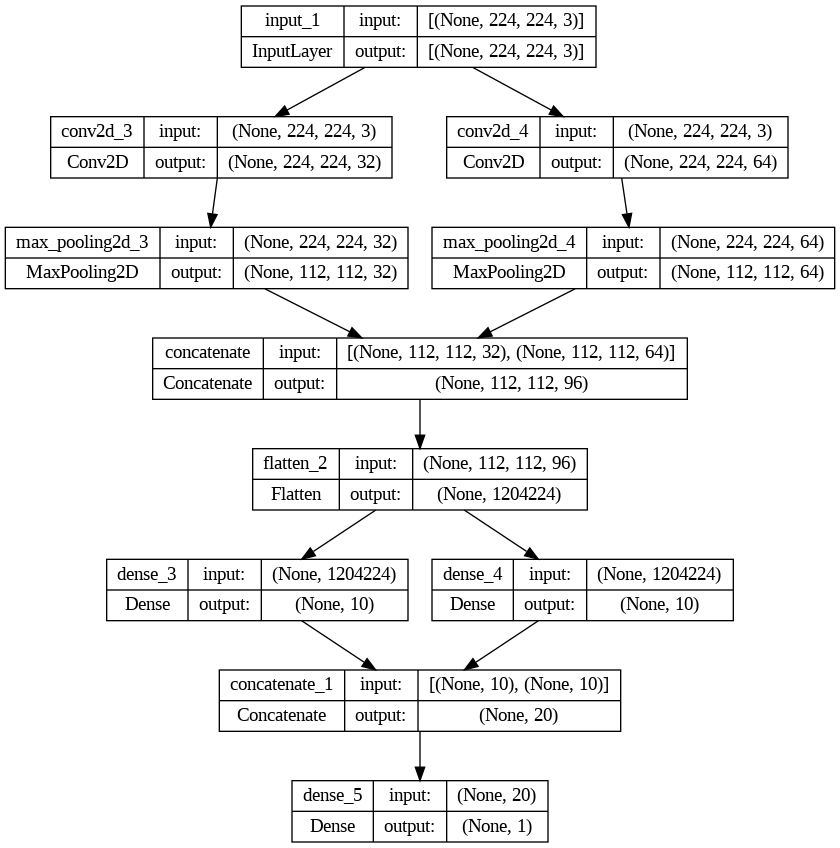

In [55]:
tf.keras.utils.plot_model(model_func, show_shapes=True)

1. `input_1 (InputLayer)`: Ini adalah lapisan input yang digunakan untuk menerima data masukan. Dalam kasus ini, bentuk masukan adalah (224, 224, 3), yang mengindikasikan gambar berwarna dengan ukuran 224x224 piksel dan 3 saluran warna (RGB).

2. `conv2d_3 (Conv2D)`: Lapisan konvolusi 2D dengan 32 filter dan ukuran kernel (3, 3). Lapisan ini digunakan untuk mengekstraksi fitur dari gambar input. Hasil keluarannya memiliki dimensi (None, 224, 224, 32).

3. `conv2d_4 (Conv2D)`: Lapisan konvolusi 2D lainnya dengan 64 filter dan ukuran kernel (3, 3). Ini juga digunakan untuk mengekstraksi fitur dari gambar input. Hasil keluarannya memiliki dimensi (None, 224, 224, 64).

4. `max_pooling2d_3 (MaxPooling2D)`: Lapisan max-pooling 2D yang digunakan untuk mengurangi dimensi spasial dari keluaran `conv2d_3`. Dalam hal ini, ukuran keluarannya menjadi (None, 112, 112, 32).

5. `max_pooling2d_4 (MaxPooling2D)`: Lapisan max-pooling 2D yang digunakan untuk mengurangi dimensi spasial dari keluaran `conv2d_4`. Hasil keluarannya memiliki dimensi (None, 112, 112, 64).

6. `concatenate (Concatenate)`: Lapisan konkatenasi yang menggabungkan keluaran dari `max_pooling2d_3` dan `max_pooling2d_4`, menghasilkan keluaran dengan dimensi (None, 112, 112, 96).

7. `flatten_2 (Flatten)`: Lapisan ini digunakan untuk mengubah keluaran dari lapisan konkatenasi menjadi bentuk vektor 1D dengan 1.204.224 elemen.

8. `dense_3 (Dense)`: Lapisan terhubung penuh dengan 10 unit. Lapisan ini digunakan untuk melakukan pembelajaran lebih lanjut pada fitur-fitur yang telah diekstraksi sebelumnya.

9. `dense_4 (Dense)`: Lapisan terhubung penuh lainnya dengan 10 unit. Ini adalah lapisan yang lebih dalam dalam jaringan dan dapat menghasilkan representasi yang lebih kompleks dari data.

10. `concatenate_1 (Concatenate)`: Lapisan konkatenasi lainnya yang menggabungkan keluaran dari `dense_3` dan `dense_4`, menghasilkan keluaran dengan dimensi (None, 20).

11. `dense_5 (Dense)`: Lapisan terhubung penuh terakhir dengan hanya satu unit. Biasanya, lapisan seperti ini digunakan untuk tugas klasifikasi biner di mana outputnya mungkin menjadi 0 atau 1.

Didalam arsitektur ini dilakukan percobaan penjalanan paralel, dengan menghubungkan layer-layer secara non-sequential.

#### Model Training

In [56]:
history_func = model_func.fit(ds_train, batch_size = BATCH,
                           epochs = epoch, validation_data = ds_val,
                           callbacks = callbacks3)

Epoch 1/21
50/50 [==============================] - 50s 936ms/step - loss: 0.9041 - precision_2: 0.5427 - val_loss: 0.6074 - val_precision_2: 0.6940 - lr: 0.0010
Epoch 2/21
50/50 [==============================] - 48s 949ms/step - loss: 0.5990 - precision_2: 0.7140 - val_loss: 0.5608 - val_precision_2: 0.8477 - lr: 0.0010
Epoch 3/21
50/50 [==============================] - 47s 940ms/step - loss: 0.5616 - precision_2: 0.7929 - val_loss: 0.5308 - val_precision_2: 0.8024 - lr: 0.0010
Epoch 4/21
50/50 [==============================] - 48s 953ms/step - loss: 0.5067 - precision_2: 0.8211 - val_loss: 0.4788 - val_precision_2: 0.8638 - lr: 0.0010
Epoch 5/21
50/50 [==============================] - 48s 953ms/step - loss: 0.4865 - precision_2: 0.8060 - val_loss: 0.4640 - val_precision_2: 0.8960 - lr: 0.0010
Epoch 6/21
50/50 [==============================] - 48s 956ms/step - loss: 0.4429 - precision_2: 0.8331 - val_loss: 0.4209 - val_precision_2: 0.8944 - lr: 0.0010
Epoch 7/21
50/50 [==========

#### Model Evaluation

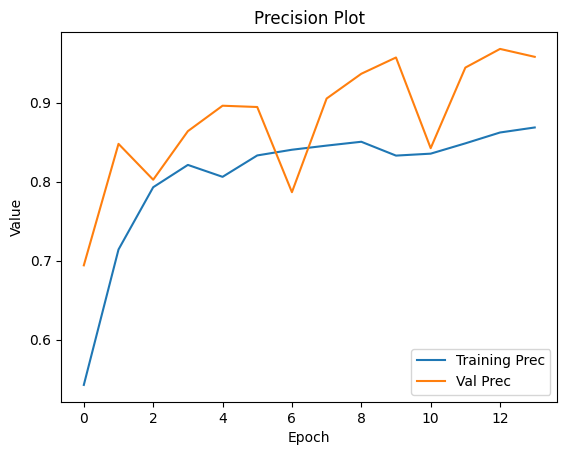

In [57]:
plt.plot(history_func.history['precision_2'], label='Training Prec')
plt.plot(history_func.history['val_precision_2'], label='Val Prec')
plt.title('Precision Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

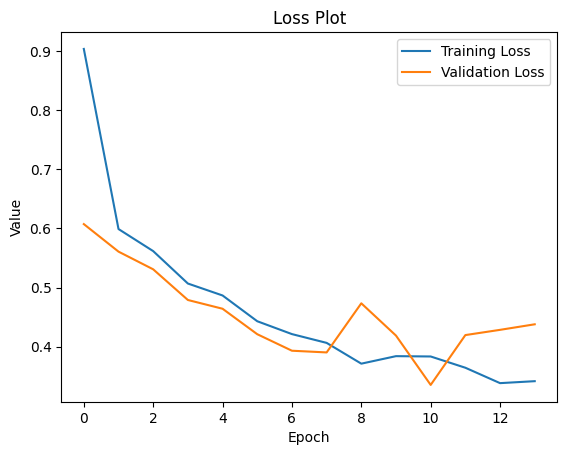

In [58]:
#loss train & validation
plt.plot(history_func.history['loss'], label='Training Loss')
plt.plot(history_func.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

In [60]:
test_results = model_func.evaluate(ds_test, verbose=0)
print(f'Test Loss     : {test_results[0]:.4f}')
print(f'Test Precision : {test_results[1]:.4f}')

Test Loss     : 0.4588
Test Precision : 0.9067


## MODEL EVALUATION

Jika dilihat dari hasil test keseluruhan ketiga model yang sudah dilakukan, terlihat bahwa model_base adalah yang terbaik, namun dikarenakan pada model ini tidak dilakukan maxpooling, ini membuat size model menjadi terlalu besar dan sulit untuk dilakukan komputasi, maka untuk seterusnya akan digunakan model terbaik kedua yaitu model_seq.

In [107]:
test_loss, test_precision = model_seq.evaluate(ds_test, verbose=2)
print()
print('Val accuracy (model_seq):', test_precision)
print('Val loss (model_seq):', test_loss)

7/7 - 1s - loss: 0.4077 - precision_1: 0.9057 - 1s/epoch - 172ms/step

Val accuracy (model_seq): 0.9056603908538818
Val loss (model_seq): 0.407725989818573


In [108]:
y_pred_test = model_seq.predict(ds_test)

7/7 [==============================] - 2s 223ms/step


              precision    recall  f1-score   support

           0       0.75      0.95      0.84       236
           1       0.92      0.64      0.76       208

    accuracy                           0.81       444
   macro avg       0.83      0.80      0.80       444
weighted avg       0.83      0.81      0.80       444



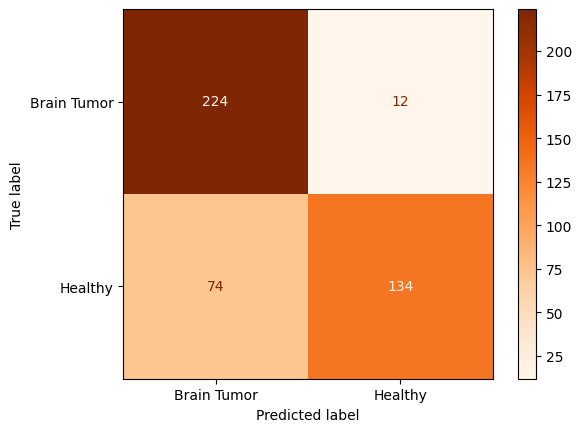

In [109]:
# confusion matrix for train
y_pred_test = (y_pred_test > 0.6).astype(int)
print(classification_report(ds_test.labels, y_pred_test))

conf_matrix = confusion_matrix(ds_test.labels, y_pred_test)
display = ConfusionMatrixDisplay(conf_matrix, display_labels=list(ds_test.class_indices.keys()))
display.plot(cmap='Oranges')

Dalam laporan tersebut, kita dapat menyimpulkan hasil evaluasi model dengan metrik presisi, recall, dan f1-score untuk klasifikasi dua kelas (0 (Brain Tumor) dan 1 (Healthy)). 

Untuk kelas 0, presisi adalah 0,75, recall adalah 0,95, dan f1-score adalah 0,84 dengan dukungan sebanyak 236 data. Ini menunjukkan bahwa model memiliki tingkat presisi yang baik untuk mengidentifikasi kelas 0, dan juga memiliki tingkat recall yang tinggi, yang berarti model ini sangat baik dalam mengenali kelas 0.

Sementara untuk kelas 1, presisi adalah 0,92, recall adalah 0,64, dan f1-score adalah 0,76 dengan dukungan sebanyak 208 data. Ini menunjukkan bahwa model memiliki tingkat presisi yang sangat baik untuk mengidentifikasi kelas 1, tetapi recall yang lebih rendah, yang berarti model mungkin lebih sering salah melewatkan data dari kelas 1.

Secara keseluruhan, akurasi model adalah 0,81, yang menunjukkan bahwa model memiliki performa yang baik secara keseluruhan. Meskipun demikian, perlu diperhatikan bahwa kelas 0 memiliki kinerja yang lebih baik daripada kelas 1. 

## MODEL SAVING

In [94]:
model_base.save('model_base.keras')

In [69]:
model_seq.save('model_seq.keras')

In [70]:
model_func.save('model_func.keras')

## INFERENCE

Dikarenakan size model yang digunakan terlalu besar, maka inference akan dilakukan di file ini dan di file inference.ipynb. Colab sudah memblokir/menthrotle komputasi dikarenakan terlalu banyak runtime dan harus menunggu cooldown, juga tidak bisa menggunakan model terbaik dikarenakan terlalu besar dan memerlukan komputasi yang besar juga. Maka akan digunakan model_seq.keras untuk inference dan juga deployment nantinya.

In [110]:
model = load_model('model_seq.keras')

In [118]:
def prediction(file):
  img = tf.keras.utils.load_img(file, target_size=(224, 224))
  x = tf.keras.utils.img_to_array(img)/255

  plt.imshow(img)

  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  idx = np.argmax(classes)
  label = ['Brain Tumor', 'Healthy']
  print('Prediction is a {}'.format(label[idx]))

1/1 [==============================] - 0s 18ms/step
Prediction is a Brain Tumor


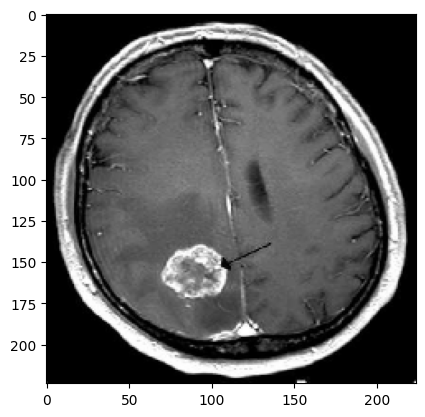

In [119]:
prediction('/content/image_2024-01-22_155703689.png')

## CONCLUSION

1. EDA :

- Distribusi data Brain Tumor (55%) terlihat lebih banyak dibandingkan Healthy (45%), Namun data pada dataset ini belum terbilang imbalanced, dikarenakan perbedaan persentase masih terbilang kecil.

- Data gambar pada dataset ini belum dilakukan data augmentation, dapat terlihat dari shape gambar yang masih berbeda-beda.

2. Model :

- Arsitektur model terbaik adalah model_base yang menggunakan arsitektur sequential tanpa maxpooling, namun size dari model ini terlalu besar dan juga akan memerlukan biaya komputasi yang sangat besar, maka untuk selanjutanya model ini tidak akan digunakan untuk inference dan deployment.

- Model yang terpilih adalah model terbaik kedua yaitu model_seq, ini adalah hasil percobaan improvement model_base, walaupun model_base memiliki nilai metrics yang lebih baik, model_seq akan digunakan dikarenakan size yang jauh lebih kecil dibanding model_base.

- metrics yang didapatkan pada model_seq,  loss: 0.4077 - precision_1: 0.9057, ini berdasarkan training sebanyak 21 epoch atau iterasi.

3. Evaluation :

- Hasil evaluasi model dengan metrik presisi, recall, dan f1-score untuk klasifikasi dua kelas (0 (Brain Tumor) dan 1 (Healthy)). 

- Untuk kelas 0, presisi adalah 0,75, recall adalah 0,95, dan f1-score adalah 0,84 dengan dukungan sebanyak 236 data. Ini menunjukkan bahwa model memiliki tingkat presisi yang baik untuk mengidentifikasi kelas 0, dan juga memiliki tingkat recall yang tinggi, yang berarti model ini sangat baik dalam mengenali kelas 0.

- Sementara untuk kelas 1, presisi adalah 0,92, recall adalah 0,64, dan f1-score adalah 0,76 dengan dukungan sebanyak 208 data. Ini menunjukkan bahwa model memiliki tingkat presisi yang sangat baik untuk mengidentifikasi kelas 1, tetapi recall yang lebih rendah, yang berarti model mungkin lebih sering salah melewatkan data dari kelas 1.

- Secara keseluruhan, akurasi model adalah 0,81, yang menunjukkan bahwa model memiliki performa yang baik secara keseluruhan. Meskipun demikian, perlu diperhatikan bahwa kelas 0 memiliki kinerja yang lebih baik daripada kelas 1. 